# Figure: the Fuzik et al. dataset

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pickle
import matplotlib

import sparseRRR

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 7
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120     # only affects the notebook

sns_styleset()

In [2]:
def preprocess(data):
    X = data['counts'][:,data['mostVariableGenes']] / np.sum(data['counts'], axis=1) * 1e+6
    X = np.array(X)
    X = np.log2(X + 1)
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    Y = data['ephys']
    Y = Y - np.mean(Y, axis=0)
    Y = Y / np.std(Y, axis=0)
    
    return (X,Y)

In [3]:
data = pickle.load(open('data/fuzik2016.pickle', 'rb'))
X,Y = preprocess(data)
print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

cvresults = pickle.load(open('pickles/cvresults-fuzik2016.pickle', 'rb'))

Shape of X: (80, 1313) 
Shape of Y: (80, 80)


<IPython.core.display.Javascript object>


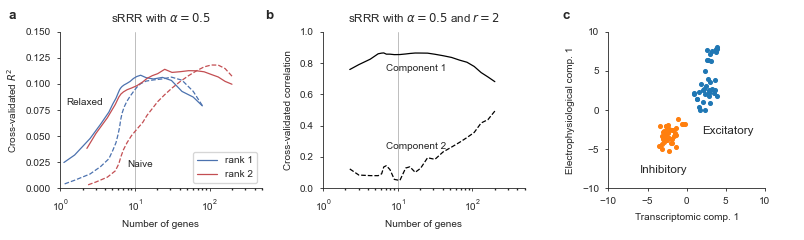

Genes selected: 10


In [4]:
import warnings

fig = plt.figure(figsize=(6.7, 2))

plt.subplot(131)
cols = ['', [76/256, 114/256, 176/256], [196/256, 78/256, 82/256]]
for rank in range(1,2+1):
    # suppressing "mean of empty slice" warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        n = np.nanmean(cvresults[rank][2], axis=(0,1))
        c = np.nanmean(cvresults[rank][0], axis=(0,1))
        cr = np.nanmean(cvresults[rank][1], axis=(0,1))
    
        col = cols[rank]
        plt.plot(n[:,0], cr[:,0], color=col, linewidth=.75,
                 label='rank {}'.format(rank))
        plt.plot(n[:,0], c[:,0], '--',  color=col, linewidth=.75)

plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel('Number of genes')
plt.ylabel(r'Cross-validated $R^2$')
plt.title(r'sRRR with $\alpha=0.5$')
plt.ylim([0, .15])
plt.xlim([1, 500])
plt.text(1.2, .08, 'Relaxed', fontsize=6)
plt.text(8,.02, 'Naive', fontsize=6)
plt.plot([10,10], [0,.15], color=[.7,.7,.7], linewidth=.5, zorder=0)

plt.subplot(132)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n = np.nanmean(cvresults[2][2], axis=(0,1))
    c = np.nanmean(cvresults[2][4], axis=(0,1))
    
plt.plot(n[:,0], c[:,0,0], color='k', linewidth=.75,
                 label='rank {}'.format(rank))
plt.plot(n[:,0], c[:,0,1], 'k--', linewidth=.75)

# plt.legend(frameon=False, bbox_to_anchor=(1, 1.05))
plt.xscale('log')
plt.xlabel('Number of genes')
plt.ylabel('Cross-validated correlation')
plt.title(r'sRRR with $\alpha=0.5$ and $r=2$')
plt.ylim([0, 1])
plt.xlim([1, 500])
plt.text(7, .75, 'Component 1', fontsize=6)
plt.text(7, .25, 'Component 2', fontsize=6)
plt.plot([10,10], [0,1], color=[.7,.7,.7], linewidth=.5, zorder=0)


#########
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=1, alpha = .5, lambdau = 2)
print('Genes selected:', np.sum(w!=0))

plt.subplot(133, aspect='equal')
ind = np.isin(data['cluster'], ['L5', 'L4', 'L2'])
plt.scatter(X[ind,:]@w, Y[ind,:]@v, s=5)
plt.scatter(X[~ind,:]@w, Y[~ind,:]@v, s=5)
plt.text(2,-3,'Excitatory', fontsize=7)
plt.text(-6,-8,'Inhibitory', fontsize=7)
# plt.title(r'sRRR with $\alpha=0.5$ and $r=1$')
plt.xlabel('Transcriptomic comp. 1')
plt.ylabel('Electrophysiological comp. 1')
plt.xlim([-10,10])
plt.ylim([-10,10])

sns.despine()
plt.tight_layout()

fig.text(.01, .92, 'a', fontsize=8, fontweight='bold')
fig.text(.33, .92, 'b', fontsize=8, fontweight='bold')
fig.text(.70, .92, 'c', fontsize=8, fontweight='bold')

plt.savefig('figures/fuzik.png', dpi=200)
plt.savefig('figures/fuzik.pdf')